In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pickle 
import pickle
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *


def merge_capacity_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_capacities
        capacities = capacities.append(df,ignore_index=True)
    return capacities


#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030_low.csv'

# Params
timesteps=24*30
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

#ss_factors = [i/100 for i in np.arange(10,101,10).tolist()]
ss_factors = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]
#ss_factors = [0.6,0.7,0.8,0.9,0.95]

## RUN COO

In [2]:
results = {}
coo_caps = []
coo_costs = []
for s in ss_factors:
    print(f'> Running factor {s}')
    model_run = nextra(nodes,edges,flows,
                       scenario='COO',
                       energy_objective=True,
                       timesteps=timesteps,
                       coo_res_factor=s)

    model_run.build()
    model_run.run(pprint=False)
    try:
        model_results = model_run.get_results()
        # add scenarios to results
        # if s == 'BAU' and scenarios[s] == False:
        #     s = 'BAS'
        model_results.results_capacities['self_sufficiency_factor']       = s
        model_results.results_storages['self_sufficiency_factor']         = s
        model_results.results_edge_flows['self_sufficiency_factor']       = s
        model_results.results_capacity_change['self_sufficiency_factor']  = s
        model_results.results_costs['self_sufficiency_factor']            = s
        # append results
        results[ 'COO_' + str(s) ] = model_results
        # append into list
        m = model_results.get_capacities()
        coo_caps.append(pd.DataFrame({'Technology' : ['Solar'],
                                  'Factor' : s,
                                  'Capacity' : m.loc[m.technology.isin(['Solar'])].value.sum() / 1000}))
                    
        coo_caps.append(pd.DataFrame({'Technology' : ['Wind'],
                                  'Factor' : s,
                                  'Capacity' : m.loc[m.technology.isin(['Wind'])].value.sum() / 1000 }))
        
        coo_caps.append(pd.DataFrame({'Technology' : ['Battery'],
                                  'Factor' : s,
                                  'Capacity' : m.loc[m.technology.isin(['Battery'])].value.sum() / 1000}))
        
        coo_costs.append(pd.DataFrame({'Factor':[s], 'Cost':model_results.results_costs.totex.sum()}))
    except:
        print('> FAILED! ' + str(s))

> Running factor 0.1
Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-07-10

> Running factor 0.2

> Running factor 0.3

> Running factor 0.4

> Running factor 0.5

> Running factor 0.6

> Running factor 0.7

> Running factor 0.8

> Running factor 0.9

> Running factor 0.95



## RUN NCO

In [3]:
results = {}
nco_caps = []
nco_costs = []
for s in ss_factors:
    print(f'> Running factor {s}')
    model_run = nextra(nodes,edges,flows,
                       scenario='NCO',
                       gaz_res_target_2030=s,
                       pal_res_target_2030=s,
                       jor_res_target_2030=s,
                       isr_res_target_2030=s,
                       energy_objective=True,
                       timesteps=timesteps)

    model_run.build()
    model_run.run(pprint=False)
    try:
        model_results = model_run.get_results()
        # add scenarios to results
        # if s == 'BAU' and scenarios[s] == False:
        #     s = 'BAS'
        model_results.results_capacities['self_sufficiency_factor']       = s
        model_results.results_storages['self_sufficiency_factor']         = s
        model_results.results_edge_flows['self_sufficiency_factor']       = s
        model_results.results_capacity_change['self_sufficiency_factor']  = s
        model_results.results_costs['self_sufficiency_factor']            = s
        # append results
        results[ 'COO_' + str(s) ] = model_results
        # append into list
        m = model_results.get_capacities()
        nco_caps.append(pd.DataFrame({'Technology' : ['Solar'],
                                  'Factor' : s,
                                  'Capacity' : m.loc[m.technology.isin(['Solar'])].value.sum() / 1000}))
                    
        nco_caps.append(pd.DataFrame({'Technology' : ['Wind'],
                                  'Factor' : s,
                                  'Capacity' : m.loc[m.technology.isin(['Wind'])].value.sum() / 1000 }))
        
        nco_caps.append(pd.DataFrame({'Technology' : ['Battery'],
                                  'Factor' : s,
                                  'Capacity' : m.loc[m.technology.isin(['Battery'])].value.sum() / 1000}))
        
        nco_costs.append(pd.DataFrame({'Factor':[s],'Cost':model_results.results_costs.totex.sum()}))
            
    except:
        print('> FAILED! ' + str(s))

> Running factor 0.1

> Running factor 0.2

> Running factor 0.3

> Running factor 0.4

> Running factor 0.5

> Running factor 0.6

> Running factor 0.7

> Running factor 0.8

> Running factor 0.9

> Running factor 0.95



In [4]:
coo_caps_merged = pd.concat(coo_caps,ignore_index=True)
nco_caps_merged = pd.concat(nco_caps,ignore_index=True)

coo_caps_merged['Scenario'] = 'COO'
nco_caps_merged['Scenario'] = 'NCO'

capacity_data = coo_caps_merged.append(nco_caps_merged,ignore_index=True)

# COSTS
nco_costs_merged = pd.concat(nco_costs)
coo_costs_merged = pd.concat(coo_costs)

coo_costs_merged['Scenario'] = 'COO'
nco_costs_merged['Scenario'] = 'NCO'

cost_data = coo_costs_merged.append(nco_costs_merged,ignore_index=True)

In [5]:
coo_cost = cost_data.loc[(cost_data.Factor == 0.95) & (cost_data.Scenario == 'COO'),'Cost'].iloc[0]
nco_cost = cost_data.loc[(cost_data.Factor == 0.95) & (cost_data.Scenario == 'NCO'),'Cost'].iloc[0]
delta = nco_cost - coo_cost

print(f'>>> Cost saving to achieve net zero is: $US{int(delta*10**-9)} billion')

>>> Cost saving to achieve net zero is: $US29 billion


In [6]:
capacity_data.groupby(by='Technology').sum()

,Factor,Capacity
Technology,,
Battery,10.9,1338.233799
Solar,10.9,676.039698
Wind,10.9,130.717856


In [7]:
demands = results['COO_0.6'].flows[results['COO_0.6'].flows.node.str.contains('demand')]
demands.groupby(by='year').sum().reset_index().value * 10**-3

0    11043.077569
Name: value, dtype: float64

In [8]:
sources = get_source_nodes(results['COO_0.6'].nodes).name.to_list()
supplies = results['COO_0.6'].results_edge_flows[results['COO_0.6'].results_edge_flows.from_id.isin(sources)]

supplies.groupby(by='year').sum().reset_index().value * 10**-3

0    11595.231447
Name: value, dtype: float64

In [11]:
11595/11043*100

104.9986416734583

In [13]:
sums = capacity_data.groupby(by=['Factor','Scenario']).sum().reset_index()
sums.Factor = sums.Factor * 100
sums.Capacity = sums.Capacity.round(0)

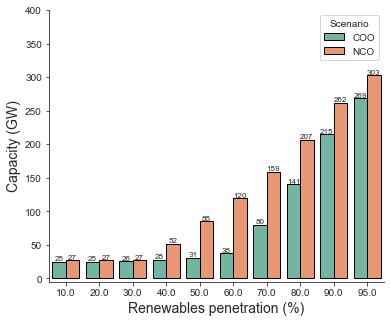

In [15]:
f,ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

sns.set_style("ticks")

sns.barplot(x='Factor',
            y='Capacity',
            hue='Scenario',
            data=sums,
            ax=ax,
            palette='Set2',
            edgecolor='black',
           )

ax.set_xlabel('Renewables penetration (%)',fontsize=14)
ax.set_ylabel('Capacity (GW)',fontsize=14)
ax.set_ylim([-5,400])

for container in ax.containers:
    ax.bar_label(container,fontsize=8)

sns.despine()

f.savefig('../outputs/figures/oms_net_zero.png',dpi=450,bbox_inches='tight')

In [ ]:
results['COO_0.95'].plot_flows_sankey()

In [ ]:
model_results.results_costs.totex.sum()

In [ ]:
sns.barplot(x='Factor',y='Capacity',
             data=capacity_data.groupby(by='Factor').sum().reset_index())

In [ ]:
results['COO_0.95'].plot_hourly_profile(day=4,month=1)

In [ ]:
results['COO_0.95'].plot_flows_sankey()

In [ ]:
results['COO_0.9'].results_costs.totex.sum()